In [15]:


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D


=== Tabular Approach ===
              precision    recall  f1-score   support

       blues       0.65      0.85      0.74        20
   classical       1.00      1.00      1.00        13
     country       0.76      0.59      0.67        27
       disco       0.83      0.71      0.77        21
      hiphop       0.59      0.87      0.70        15
        jazz       0.91      0.95      0.93        22
       metal       0.86      0.96      0.91        25
         pop       0.82      0.69      0.75        13
      reggae       0.70      0.61      0.65        23
        rock       0.61      0.52      0.56        21

    accuracy                           0.77       200
   macro avg       0.77      0.78      0.77       200
weighted avg       0.77      0.77      0.76       200



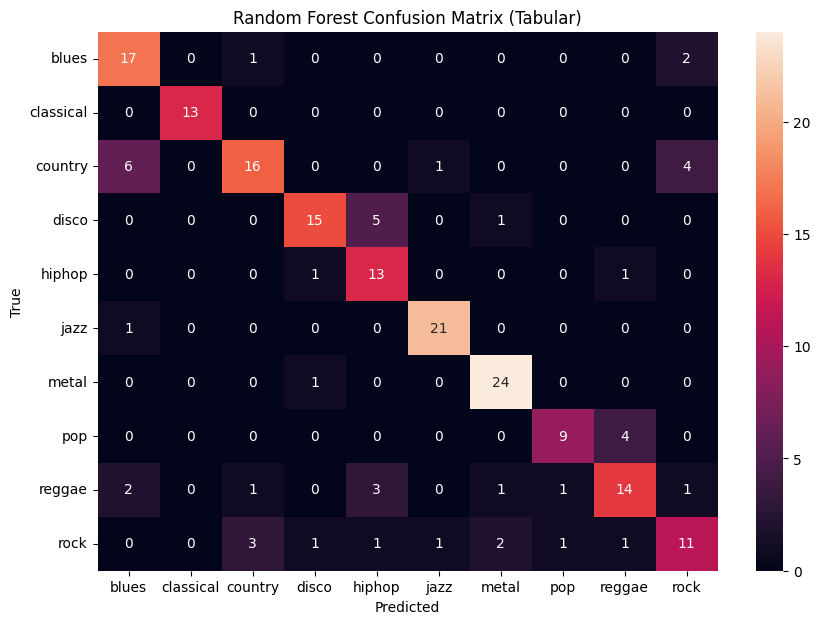

Random Forest Accuracy (Tabular Features): 0.77


In [16]:
# -------------------------------
# 2. Tabular Approach (CSV Features)
# -------------------------------
# Load CSV features
df = pd.read_csv("Data/features_30_sec.csv")  # adjust path


# Features = all numeric columns except 'filename' and 'label'
X = df.drop(columns=['filename', 'label']).values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predictions & evaluation
y_pred = rf.predict(X_test)
print("=== Tabular Approach ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Random Forest Confusion Matrix (Tabular)")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

tabular_acc = np.mean(y_pred == y_test)
print(f"Random Forest Accuracy (Tabular Features): {tabular_acc:.2f}")


In [ ]:
# -------------------------------
# 3. Image-Based Approach (CNN with Transfer Learning)
# -------------------------------
img_dir = "Data/images_original"  
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    img_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    img_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Transfer Learning with ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(len(train_gen.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(train_gen, validation_data=val_gen, epochs=15)

# Plot training history
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("CNN (ResNet50) Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

cnn_acc = history.history['val_accuracy'][-1]
print(f"CNN Accuracy (Spectrograms with ResNet50): {cnn_acc:.2f}")


In [19]:
# -------------------------------
# 4. Compare Approaches
# -------------------------------
print("\n=== Comparison ===")
print(f"Random Forest (Tabular): {tabular_acc:.2f}")
print(f"CNN (Spectrogram + ResNet50): {cnn_acc:.2f}")

if cnn_acc > tabular_acc:
    print("CNN with transfer learning outperformed the tabular approach.")
else:
    print("Random Forest performed surprisingly well; tabular features captured enough info.")


=== Comparison ===
Random Forest (Tabular): 0.77
CNN (Spectrogram + ResNet50): 0.20
Random Forest performed surprisingly well; tabular features captured enough info.
